In [1]:
import numpy as np
import pandas as pd
import re
import unicodedata
import re
import nltk
import nltk.sentiment
import matplotlib.pyplot as plt
import seaborn as sns

import acquire
import prepare
import wrangle

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from random import sample
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('npr_corpus.csv')
df.head()

,Unnamed: 0,episode_id,episode_order,speaker,utterance,program,title,episode_date,is_host,clean,lemmatized,lemmatized_stopped
0,0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,False,it s a 2200 mile race. to give some sense of p...,it s a 2200 mile race. to give some sense of p...,2200 mile race. give sense perspective roughly...
1,1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,top competitor like lance try make much time 1...
2,2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,so in every team presumably there s one star o...,so in every team presumably there s one star o...,every team presumably one star one equivalent ...
3,3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,right. team ha nine riders. basically team lea...
4,4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,so slipstream this is like drafting in car rac...,so slipstream this is like drafting in car rac...,slipstream like drafting car racing right ?


In [3]:
df['date'] = pd.to_datetime(df.episode_date)
df['year'] = pd.DatetimeIndex(df['date']).year

In [4]:
is_hosts_df = df[df.is_host == True]
is_hosts_df.head()

,Unnamed: 0,episode_id,episode_order,speaker,utterance,program,title,episode_date,is_host,clean,lemmatized,lemmatized_stopped,date,year
2,2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,so in every team presumably there s one star o...,so in every team presumably there s one star o...,every team presumably one star one equivalent ...,2010-07-12,2010
4,4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,so slipstream this is like drafting in car rac...,so slipstream this is like drafting in car rac...,slipstream like drafting car racing right ?,2010-07-12,2010
6,6,57264,15,"NEAL CONAN, host",And so the guy who's in back has an easier tim...,Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,and so the guy who s in back has an easier tim...,and so the guy who s in back ha an easier time...,guy back ha easier time. even people front bre...,2010-07-12,2010
8,8,57264,17,"NEAL CONAN, host","We're talking with Loren Mooney, the editor-in...",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,we re talking with loren mooney the editor in ...,we re talking with loren mooney the editor in ...,talking loren mooney editor chief bicycling ma...,2010-07-12,2010
10,10,57264,19,"NEAL CONAN, host","Hi, John.",Talk of the Nation,How To Watch The Tour De France,2010-07-12,True,hi john .,hi john .,hi john .,2010-07-12,2010


### WordClouds

- Data goes from the years 1999 - 2019
- I am excluding the years 1999 - 2005. 1999 is fine, but 2001 - 2004 either have little/no values.

In [5]:
all_words = ' '.join(str(df.lemmatized_stopped))

all_freq = pd.Series(all_words.split()).value_counts()
all_freq_df = all_freq.to_frame().reset_index()

all_freq_df.columns = ['wrd', 'cnt']

stop_words = []

for word in all_freq_df.wrd:
    if len(word) < 3:
        stop_words.append(word)

In [6]:
def remove_stopwords(string, extra_words = [], exclude_words = []):
    '''
    Takes a string and removes stopwords.
    Optional arguments: 
    extra_words adds words to stopword list
    exclude_words words to keep
    '''
    # create stopword list
    stopword_list = stopwords.words('english')
    # remove excluded words
    stopword_list = set(stopword_list) - set(exclude_words)
    # add extra words
    stopword_list = stopword_list.union(set(extra_words))

    words = string.split()

    # add word to list if it's not in the stopword_list
    filtered_words = [w for w in words if w not in stopword_list]
    # join the filtered words into a string
    string_without_stopwords = ' '.join(filtered_words)
    # return list with removed stopwords
    return string_without_stopwords

In [8]:
is_hosts_df['a_stopwords'] = [remove_stopwords(str(u), extra_words = stop_words) for u in is_hosts_df.lemmatized_stopped]
df['a_stopwords'] = [remove_stopwords(str(u), extra_words = stop_words) for u in df.lemmatized_stopped]

all_hosts_words = ' '.join(is_hosts_df.a_stopwords)
all_words = ' '.join(df.a_stopwords)

In [32]:
bush = df.a_stopwords[df['year'].isin([2005, 2006, 2007, 2008, 2009])]
bush

246        atlantic hurricane season officially end today...
247        eight hurricane formed north atlantic caribbea...
248        translator wave high top building building fiv...
249        fernandez teach history university baracoa. sa...
250        translator 60 suffered lot hurricane flora. gr...
                                 ...                        
2998297    anti gm movement warns spread called super wee...
2998298    come willamette valley extremely detrimental g...
2998299    scott company say happen. hunting stray gm gra...
2998300    plenty people right now. speculation range wor...
2998301    aphis final stage environmental impact stateme...
Name: a_stopwords, Length: 1407947, dtype: object

In [33]:
df['bush_stopwords'] = bush

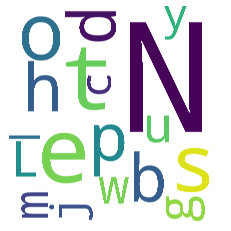

In [38]:
bush_wordc = WordCloud(background_color = 'white', width = 16000, height = 16000).generate(' '.join(str(df.bush_stopwords)))
                                                                                           
plt.imshow(bush_wordc)

plt.axis('off');

In [14]:
# 2001-2004 either contains no values or too few, so excluding Clinton's presidency and moving past to 2005

# George W. Bush [Served: 2001 - 2009] #
o_five = df.a_stopwords[df['year'] == in(2005, 2006, 2007, 2008, 2009)]
o_six = df.a_stopwords[df['year'] == 2006]
o_seven = df.a_stopwords[df['year'] == 2007]
o_eight = df.a_stopwords[df['year'] == 2008]
o_nine = df.a_stopwords[df['year'] == 2009]

bush = [(o_five, o_six, o_seven, o_eight, o_nine)]
bush = (bush)


# Barack Obama [Served: 2009 - 2017] #
o_nine = df.a_stopwords[df['year'] == 2009]
twenty_ten = df.a_stopwords[df['year'] == 2010]
twenty_eleven = df.a_stopwords[df['year'] == 2011]
twenty_twelve = df.a_stopwords[df['year'] == 2012]
twenty_thirteen = df.a_stopwords[df['year'] == 2013]
twenty_fourteen = df.a_stopwords[df['year'] == 2014]
twenty_fifteen = df.a_stopwords[df['year'] == 2015]
twenty_sixteen = df.a_stopwords[df['year'] == 2016]
twenty_seventeen = df.a_stopwords[df['year'] == 2017]

obama = [(o_nine, twenty_ten, twenty_eleven, twenty_twelve, twenty_thirteen, 
          twenty_fourteen, twenty_fifteen, twenty_sixteen, twenty_seventeen)]
obama = (obama)


# Donald J. Trump [Served: 2017 - 2021] #
twenty_seventeen = df.a_stopwords[df['year'] == 2013]
twenty_eighteen= df.a_stopwords[df['year'] == 2014]
twenty_nineteen = df.a_stopwords[df['year'] == 2015]
twenty_twenty = df.a_stopwords[df['year'] == 2016]
twenty_twentyone = df.a_stopwords[df['year'] == 2017]

trump = [(twenty_seventeen, twenty_eighteen, twenty_nineteen, twenty_twenty, twenty_twentyone)]
trump = (trump)

In [23]:
bush

[(594        npr west day day. alex chadwick away. madelein...
  595        coming democrat divided iraq. first minute tod...
  596        main stumbling block know federalism role isla...
  597        depends talking to. right main stumbling block...
  598        well speaking blood violence written political...
                                   ...                        
  2998254    early vietnam war complaint disproportionate n...
  2998255    need job outweighs risk war jobless economy be...
  2998256    see veteran today say thanks. might help sleep...
  2998257    clarence page nationally syndicated columnist ...
  2998258                                             npr news
  Name: a_stopwords, Length: 188440, dtype: object,
  272        software analysis human factor process algorit...
  273        kind situation kind topic bringing kind level ...
  274        phil tschudy cuna mutual financial service gro...
  275        say company ha trying software year feedback tool
  2

In [22]:
len(bush)

1

In [18]:
df['bush_stopwords'] = [bush]
df['obama_stopwords'] = [obama]
df['trump_stopwords'] = [trump]

ValueError: Length of values (1) does not match length of index (2998347)

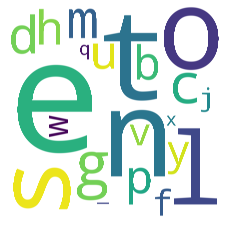

In [18]:
all_host_u = WordCloud(background_color = 'white', width = 16000, height = 16000).generate(' '.join(str(is_hosts_df.a_stopwords)))
plt.imshow(all_host_u)

plt.axis('off');

In [ ]:
all_u = WordCloud(background_color = 'white', width = 1600, height = 800).generate(' '.join(df.a_stopwords))
plt.imshow(all_u)
plt.axis('off');

In [12]:
george_bush = (bush)

w_bush = WordCloud(background_color = 'white', width = 1600, height = 800).generate(george_bush)
plt.imshow(george_bush)


barack_obama = (obama)

b_obama = WordCloud(background_color = 'white', width = 1600, height = 800).generate(barack_obama)
plt.imshow(barack_obama)


don_trump = (trump)

d_trump = WordCloud(background_color = 'white', width = 1600, height = 800).generate(don_trump)
plt.imshow(don_trump)
 

plt.figure(figsize = (10, 10))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5]), plt.axes([1.05, .5, .5, .5])]


axs[0].imshow(w_bush)
axs[1].imshow(b_obama)
axs[2].imshow(d_trump)


axs[0].set_title('George W. Bush (Served: 2001 - 2009)')
axs[1].set_title('Barack Obama (Served: 2009 - 2017)')
axs[2].set_title('Donald J. Trump (Served: 2017 - 2021)');


TypeError: expected string or bytes-like object

In [ ]:
# obtain top 10 hosts
hosts_to_keep = df[df.is_host == True].speaker.value_counts().head(10).index.to_list()
# create host df
hosts_df = df[df.speaker.isin(hosts_to_keep)]
# get episode_id of top 10 hosts
top_host_episodes = hosts_df.episode_id.value_counts().index.to_list()

In [ ]:
train, validate, test = wrangle.split_data(df)

In [ ]:
# top 10 hosts
hosts_df.speaker.value_counts().head(10).index.to_list()

In [ ]:
bigram = pd.Series(nltk.ngrams(all_words.split(), 2)).value_counts().head(20)
bigram